In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
from scipy.signal.windows import dpss
import sys

# Lambda_idx = int(sys.argv[1])
# n_external = int(sys.argv[2])
# n_chibs = int(sys.argv[3])

Lambda_idx = 18

n_external = 103
n_chibs = 2048

Lambda = Lambdas[Lambda_idx]



In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [3]:
from scipy.interpolate import interp1d
from scipy.integrate import quad, quad_vec, trapezoid

inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
f_inner_integral = interp1d(x = chibs, y = inner_dkparp_integral, axis = 1)

In [4]:
external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
print('external chi spacing', np.mean(np.diff(external_chis)))
_chibs = np.linspace(10, chimax_sample, n_chibs)
print('chib spacing', (chimax_sample - 10)/((n_chibs - 1)))

external chi spacing 21.662135908365588
chib spacing 5.353531599201998


In [5]:
interpolated_inner_integral = f_inner_integral(_chibs).astype(np.float64)

In [6]:
from tqdm import trange

In [7]:
plus = np.einsum('b,d->bd',_chibs, (1+deltas))
mins = np.einsum('b,d->bd',_chibs, (1-deltas))


In [8]:
def compute_elem(params):
    chi_idx, chi, chip_idx, chip = params
    
    f_KLIMLo1 = get_f_KILo(external_chi = chi, Lambda=Lambda)
    f_KLIMLo1_windowed = apply_window(f_K = f_KLIMLo1,
                                     chimin = chimin,
                                     chimax = chimax)
    
    f_KLIMLo2 = get_f_KILo(external_chi = chip, Lambda=Lambda)
    f_KLIMLo2_windowed = apply_window(f_K = f_KLIMLo2,
                                     chimin = chimin,
                                     chimax = chimax)

    

    _interm  = f_KLIMLo1_windowed(plus) * f_KLIMLo2_windowed(mins)
    _interm += f_KLIMLo1_windowed(mins) * f_KLIMLo2_windowed(plus) 

    _factor = (2 / _chibs)
    _factor = np.einsum('b,d->bd', _factor, deltas)
    _factor = np.einsum('bd, lbd->lbd', _factor, interpolated_inner_integral)
    
    _interm  = np.einsum('bd,lbd->lbd', 
                     _interm, _factor)
    
    
    
    d_delta_integral = trapezoid(x = np.log(deltas), y = _interm, axis=-1)

    #(ells)
    ret = trapezoid(x = _chibs, y = d_delta_integral, axis=-1)
    return (chi_idx, chip_idx, ret)

In [9]:
params_list = []

for i in range(n_external):
    chi = external_chis[i]
    for j in range(i, n_external):
        chip = external_chis[j]
        params = (i, chi, j, chip)
        params_list.append(params)

In [10]:
from tqdm import tqdm

In [11]:
from multiprocessing import Pool

with Pool(processes=32) as pool:
        results = list(tqdm(
            pool.imap(compute_elem, params_list),
            total=len(params_list)
        ))

100%|██████████| 5356/5356 [03:46<00:00, 23.68it/s]


In [12]:
#EXPORT RESULTS

In [13]:
ILoILo = np.zeros((len(ells), (n_external), (n_external)), dtype=np.float64)

In [14]:
for i, j, value in results:
    ILoILo[:,i,j] = ILoILo[:,j,i] = value

In [15]:
#EXPORT ILoILo

In [16]:
old_oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/ILo_ILo'
old_oup_fname += '_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_n_chib_%d.npy'%(zmin, 
                                                                              zmax, 
                                                                              Lambda_idx, 
                                                                              100, 
                                                                              2048)
old_ILoILo = np.load(old_oup_fname)

In [17]:
vb = np.max(np.abs(ILoILo))

([], [])

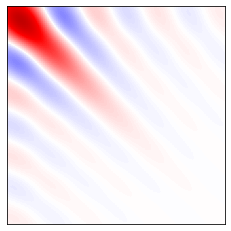

In [18]:
plt.imshow(ILoILo[0],
          vmin = -vb,
          vmax = vb,
          cmap='seismic')
plt.xticks([])
plt.yticks([])

([], [])

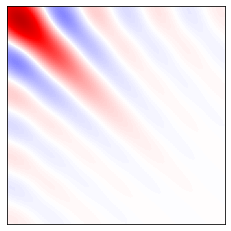

In [19]:
plt.imshow(old_ILoILo[0],
          vmin = -vb,
          vmax = vb,
          cmap='seismic')
plt.xticks([])
plt.yticks([])